# Feature Barcode pre-processing with kITE

This notebook shows how to use kallisto | bustools for fast and accurate pre-processing for Feature Barcoding experiments, a common datatype in single-cell genomics. 

In Feature Barcoding assays, cellular data are recorded as short DNA sequences using procedures adapted from single-cell RNA-seq. The __kITE ("kallisto Indexing and Tag Extraction__") workflow involves generating a "Mismatch Index" containing the sequences of all Feature Barcodes used in the experiment as well as all of their single-base mismatches. Using this Mismatch Index, kallisto | bustools will then effectively search the sequencing data for these barcodes. We find that for Feature Barcodes of moderate length (6-15bp) pre-processing is remarkably fast and the results equivalent to or better than those from traditional alignment. 

This notebook contains python scripts used to generate the required kallisto index starting with a list of __Feature Barcodes in fasta format__. To illustrate their use, data from the 10x Genomics __pbmc_1k_protein_v3__ dataset were used and the results compared with CellRanger. 

### Install and test kite

Use the Terminal to __Navigate to a new working directory__ and __download kite from GitHub__

```
git clone https://github.com/jgehringUCB/kite 
```

In [1]:
!pip install --force-reinstall -e ./kite

Obtaining file:///home/jgehring/scRNAseq/kITE/10xTest/kite
  Found existing installation: kitefeaturebarcoding 0.1
    Uninstalling kitefeaturebarcoding-0.1:
      Successfully uninstalled kitefeaturebarcoding-0.1
  Running setup.py develop for kitefeaturebarcoding


In [2]:
import kite

In [3]:
kite.version()

0.0.1


### Download Dataset - raw fastqs

Link to data download page: https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_protein_v3

In [4]:
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_fastqs.tar
!tar -xvf ./pbmc_1k_protein_v3_fastqs.tar

--2019-06-27 20:35:16--  http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_fastqs.tar
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.35.99.77, 13.35.99.80, 13.35.99.113, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.35.99.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4658677760 (4.3G) [application/x-tar]
Saving to: ‘pbmc_1k_protein_v3_fastqs.tar’

100%[====================================>] 4,658,677,760  102MB/s   in 41s    

2019-06-27 20:35:58 (107 MB/s) - ‘pbmc_1k_protein_v3_fastqs.tar’ saved [4658677760/4658677760]

pbmc_1k_protein_v3_fastqs/
pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/
pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz
pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1k_protein_v3_antibody_S2_L001_I1_001.fastq.gz
pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1

We should also grab the antibody barcode sequences which 10x Genomics has placed in a csv file. 

In [5]:
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_feature_ref.csv

--2019-06-27 20:36:02--  http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_feature_ref.csv
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.35.99.80, 13.35.99.113, 13.35.99.119, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.35.99.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1473 (1.4K) [text/csv]
Saving to: ‘pbmc_1k_protein_v3_feature_ref.csv’

100%[======================================>] 1,473       --.-K/s   in 0s      

2019-06-27 20:36:02 (134 MB/s) - ‘pbmc_1k_protein_v3_feature_ref.csv’ saved [1473/1473]



And I'll copy the CellRanger cell barcode whitelist here as well. You can download it as part of CellRanger. See this link https://kb.10xgenomics.com/hc/en-us/articles/115004506263-What-is-a-barcode-whitelist-

In [6]:
!cp ~/cellranger-3.0.0/cellranger-cs/3.0.0/lib/python/cellranger/barcodes/3M-february-2018.txt.gz ./
!gunzip ./3M-february-2018.txt.gz

In [7]:
!ls

10x_kiteVignette.ipynb	pbmc_1k_protein_v3_fastqs
3M-february-2018.txt	pbmc_1k_protein_v3_fastqs.tar
kite			pbmc_1k_protein_v3_feature_ref.csv


### Prepare a fasta file of Feature Barcodes

Create a fasta file containing only the Feature Barcode sequences (no common or constant sequences) and corresponding Feature Names used in the experiment. Place this file in the same directory as the raw fastq files. In this case, 10x has provided a csv file that I parse using the get_tags function below. The objects tags is the Python Feature Barocde dictionary that I need for kite. 

In [8]:
import csv

In [9]:
def get_tags(filename):
    with open(filename, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file)
        tags = {}
        next(csv_reader)
        for row in csv_reader:
            tags[row[1].strip()] = row[4].strip()
    return tags

tags = get_tags('./pbmc_1k_protein_v3_feature_ref.csv')

There are 17 Feature Barcodes in this experiment.

In [10]:
tags

{'CD3_TotalSeqB': 'AACAAGACCCTTGAG',
 'CD4_TotalSeqB': 'TACCCGTAATAGCGT',
 'CD8a_TotalSeqB': 'ATTGGCACTCAGATG',
 'CD14_TotalSeqB': 'GAAAGTCAAAGCACT',
 'CD15_TotalSeqB': 'ACGAATCAATCTGTG',
 'CD16_TotalSeqB': 'GTCTTTGTCAGTGCA',
 'CD56_TotalSeqB': 'GTTGTCCGACAATAC',
 'CD19_TotalSeqB': 'TCAACGCTTGGCTAG',
 'CD25_TotalSeqB': 'GTGCATTCAACAGTA',
 'CD45RA_TotalSeqB': 'GATGAGAACAGGTTT',
 'CD45RO_TotalSeqB': 'TGCATGTCATCGGTG',
 'PD-1_TotalSeqB': 'AAGTCGTGAGGCATG',
 'TIGIT_TotalSeqB': 'TGAAGGCTCATTTGT',
 'CD127_TotalSeqB': 'ACATTGACGCAACTA',
 'IgG2a_control_TotalSeqB': 'CTCTATTCAGACCAG',
 'IgG1_control_TotalSeqB': 'ACTCACTGGAGTCTC',
 'IgG2b_control_TotalSeqB': 'ATCACATCGTTGCCA'}

### Prepare mismatch fasta and t2g files

Now call the kITE_Mismatch_Maps function with a fasta file of whitelist Feature Barcodes and destination paths for a newly generated mismatch t2g and mismatch fasta. 

In [11]:
"t2g_path is where your t2g file will be placed. This file is used by the bustools count function"
t2g_path = "./10xFeatures_t2g.txt"

"fasta_path is where your fasta file will be placed. This file is used by the kallisto function"
fasta_path= "./10xFeaturesMismatch.fa"

kite.kite_mismatch_maps(tags, t2g_path, fasta_path)

Feature Barcode Length: 15

Read the following Feature Barcodes:
CD3_TotalSeqB
AACAAGACCCTTGAG
CD4_TotalSeqB
TACCCGTAATAGCGT
CD8a_TotalSeqB
ATTGGCACTCAGATG
CD14_TotalSeqB
GAAAGTCAAAGCACT
CD15_TotalSeqB
ACGAATCAATCTGTG
CD16_TotalSeqB
GTCTTTGTCAGTGCA
CD56_TotalSeqB
GTTGTCCGACAATAC
CD19_TotalSeqB
TCAACGCTTGGCTAG
CD25_TotalSeqB
GTGCATTCAACAGTA
CD45RA_TotalSeqB
GATGAGAACAGGTTT
CD45RO_TotalSeqB
TGCATGTCATCGGTG
PD-1_TotalSeqB
AAGTCGTGAGGCATG
TIGIT_TotalSeqB
TGAAGGCTCATTTGT
CD127_TotalSeqB
ACATTGACGCAACTA
IgG2a_control_TotalSeqB
CTCTATTCAGACCAG
IgG1_control_TotalSeqB
ACTCACTGGAGTCTC
IgG2b_control_TotalSeqB
ATCACATCGTTGCCA


The needed fasta and t2g files are ready

In [12]:
!ls '../10xTest/'

10xFeaturesMismatch.fa	kite
10xFeatures_t2g.txt	pbmc_1k_protein_v3_fastqs
10x_kiteVignette.ipynb	pbmc_1k_protein_v3_fastqs.tar
3M-february-2018.txt	pbmc_1k_protein_v3_feature_ref.csv


# From here, kallisto | bustools is followed in a standard analysis

With the files produced above, the kallisto single-cell pipeline is employed using the mismatch fasta and t2g files generated above. In kallisto index, the mismatch fasta is used along with a k-mer length equal the length of the Feature Barcode. In bustools count, the mismatch t2g file is referenced. 


    
The rest of this notebook completes the analysis using kallisto | bustools and compares the results to CellRanger. 

In [13]:
"""
Generate a kallisto index, setting the k-mer length k to the Feature Barcode length.
"""

!kallisto index -i ./10xFeaturesMismatch.idx -k 15 ./10xFeaturesMismatch.fa


[build] loading fasta file ./10xFeaturesMismatch.fa
[build] k-mer length: 15
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 782 contigs and contains 782 k-mers 



In [14]:
"""
Inspect the index
"""

!kallisto inspect ./10xFeaturesMismatch.idx

[index] k-mer length: 15
[index] number of targets: 782
[index] number of k-mers: 782
[index] number of equivalence classes: 782
#[inspect] Index version number = 10
#[inspect] k = 15
#[inspect] number of targets = 782
#[inspect] number of equivalence classes = 782
#[inspect] number of contigs = 782
#[inspect] Number of k-mers in index = 782
#EC.size	Num.targets
1	782


#EC.size	Num.kmers
1	782


In [15]:
"""
Call kallisto bus using the directory of the desired fastq files, the index to be used,
sequencing technology used, number of threads, and output folder
"""

!/home/jgehring/kallisto-0.46.0/build/src/kallisto bus -i ./10xFeaturesMismatch.idx -o ./ -x 10xv3 -t 4 \
./pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz \
./pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz \
./pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz \
./pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz \



[index] k-mer length: 15
[index] number of targets: 782
[index] number of k-mers: 782
[index] number of equivalence classes: 782
[quant] will process sample 1: ./pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz
                               ./pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz
[quant] will process sample 2: ./pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz
                               ./pbmc_1k_protein_v3_fastqs/pbmc_1k_protein_v3_antibody_fastqs/pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 12,606,650 reads, 11,517,927 reads pseudoaligned


In [16]:
"""
Call bustools correct to error-correct the barcodes
"""

!bustools correct -w ./3M-february-2018.txt ./output.bus -o ./output_corrected.bus


Found 6794880 barcodes in the whitelist
Number of hamming dist 1 barcodes = 6794880
Processed 11517927 bus records, rescued 11274698 records


In [17]:
"""
Call bustools sort to sort the BUS file
"""

!bustools sort -t 4 -o ./output_sorted.bus ./output_corrected.bus

Read in 11274698 number of busrecords
All sorted


In [18]:
"""
Call bustools count to generate an error-corrected genes x cells matrix
You will need the t2g file generated earlier as well as standard BUS outputs
"""

!mkdir ./genecount/

!bustools count -o ./genecount/genecounts --genecounts -g ./10xFeatures_t2g.txt -e ./matrix.ec -t ./transcripts.txt ./output_sorted.bus


bad counts = 0, rescued  =0, compacted = 0


In [19]:
"""
Call bustools count to generate an error-corrected tccs x cells matrix
You will need the t2g file generated earlier as well as standard BUS outputs
The tccs file is useful to for QC of the Feature Barcoding experiment.
"""

!mkdir /home/jgehring/scRNAseq/kITE/10xTest/tcc

!bustools count -o ./tcc/tcc -g ./10xFeatures_t2g.txt -e ./matrix.ec -t ./transcripts.txt ./output_sorted.bus


bad counts = 0, rescued  =217516, compacted = 0


The pre-processing is done, and the data can now be analyzed using, for example, the ScanPy single-cell analysis package. 

In [20]:
import scanpy.api as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

genes=sc.read_mtx('./genecount/genecounts.mtx')

In [21]:
genes

AnnData object with n_obs × n_vars = 122222 × 17 

In [22]:
genes.var_names=pd.read_csv('/home/jgehring/scRNAseq/kITE/10xTest/genecount/genecounts.genes.txt', header=None)[0]
genes.obs_names=pd.read_csv('/home/jgehring/scRNAseq/kITE/10xTest/genecount/genecounts.barcodes.txt', header=None)[0]


In [23]:
genes.var_names

Index(['CD3_TotalSeqB', 'CD4_TotalSeqB', 'CD8a_TotalSeqB', 'CD14_TotalSeqB',
       'CD15_TotalSeqB', 'CD16_TotalSeqB', 'CD56_TotalSeqB', 'CD19_TotalSeqB',
       'CD25_TotalSeqB', 'CD45RA_TotalSeqB', 'CD45RO_TotalSeqB',
       'PD-1_TotalSeqB', 'TIGIT_TotalSeqB', 'CD127_TotalSeqB',
       'IgG2a_control_TotalSeqB', 'IgG1_control_TotalSeqB',
       'IgG2b_control_TotalSeqB'],
      dtype='object', name=0)

In [24]:
print(sum(genes.X))

  (0, 0)	847141.0
  (0, 1)	986108.0
  (0, 2)	319722.0
  (0, 3)	611893.0
  (0, 4)	288525.0
  (0, 5)	170755.0
  (0, 6)	128380.0
  (0, 7)	97891.0
  (0, 8)	80530.0
  (0, 9)	1576777.0
  (0, 10)	350525.0
  (0, 11)	157711.0
  (0, 12)	66301.0
  (0, 13)	142417.0
  (0, 14)	62146.0
  (0, 15)	77796.0
  (0, 16)	19316.0


In [25]:
sc.pp.filter_cells(genes,min_counts=0)

In [26]:
sc.pp.filter_genes(genes,min_counts=0)

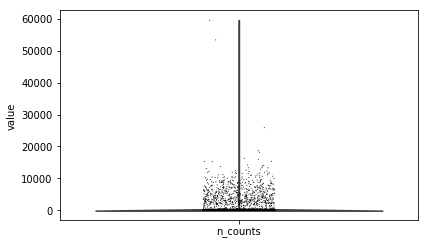

In [27]:
sc.pl.violin(genes, keys='n_counts')

In [28]:
genes.obs['n_countslog']=np.log1p(genes.obs['n_counts'])

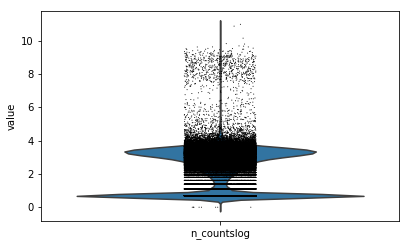

In [29]:
sc.pl.violin(genes, keys='n_countslog')

In [30]:
genes.obs_names

Index(['AAACCCAAGAAACCCA', 'AAACCCAAGACGAGGA', 'AAACCCAAGAGTGTGT',
       'AAACCCAAGAGTGTTG', 'AAACCCAAGATAGCAC', 'AAACCCAAGATGAGTC',
       'AAACCCAAGATGGTAC', 'AAACCCAAGATTCGTT', 'AAACCCAAGATTTGGG',
       'AAACCCAAGCAAGCAT',
       ...
       'TTTGTTGTCGTCGCCT', 'TTTGTTGTCGTTGACG', 'TTTGTTGTCTAACCGG',
       'TTTGTTGTCTATGTAG', 'TTTGTTGTCTCAACAA', 'TTTGTTGTCTCACTCA',
       'TTTGTTGTCTCTTCGA', 'TTTGTTGTCTCTTGGT', 'TTTGTTGTCTGCACTT',
       'TTTGTTGTCTGCGACA'],
      dtype='object', name=0, length=122222)

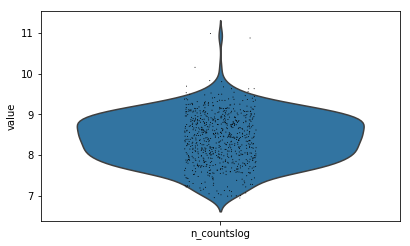

AnnData object with n_obs × n_vars = 725 × 17 
    obs: 'n_counts', 'n_countslog'
    var: 'n_counts'

In [31]:
sc.pp.filter_cells(genes, min_counts=1000)
sc.pl.violin(genes, keys='n_countslog')
genes

In [32]:
sc.pp.normalize_per_cell(genes, counts_per_cell_after=10000)

In [33]:
sc.pp.neighbors(genes)

sc.tl.umap(genes)

In [34]:
sc.tl.leiden(genes, resolution=0.05)

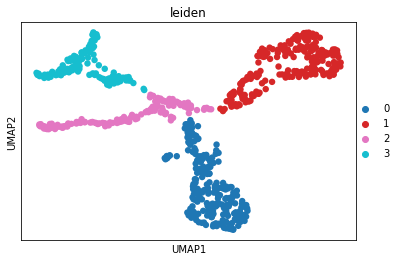

In [35]:
sc.pl.umap(genes, color='leiden', palette='tab10')

We can download the 10x Feature Barcodes x Cells matrix for comparison

In [36]:
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_filtered_feature_bc_matrix.tar.gz -P ../

--2019-06-27 20:37:11--  http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.35.99.113, 13.35.99.119, 13.35.99.77, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.35.99.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5537246 (5.3M) [application/x-tar]
Saving to: ‘../pbmc_1k_protein_v3_filtered_feature_bc_matrix.tar.gz.5’

100%[======================================>] 5,537,246   --.-K/s   in 0.08s   

2019-06-27 20:37:12 (63.5 MB/s) - ‘../pbmc_1k_protein_v3_filtered_feature_bc_matrix.tar.gz.5’ saved [5537246/5537246]



In [37]:
!tar xvzf ../pbmc_1k_protein_v3_filtered_feature_bc_matrix.tar.gz

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/features.tsv.gz
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/barcodes.tsv.gz


In [38]:
!ls ../filtered_feature_bc_matrix/

barcodes.tsv.gz  features.tsv.gz  matrix.mtx.gz


In [39]:
tenx = sc.read_mtx('../filtered_feature_bc_matrix/matrix.mtx.gz').T

In [40]:

tenx.var_names=pd.read_csv('../filtered_feature_bc_matrix/features.tsv.gz', delimiter='\t', header=None)[1]



Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [41]:
tenx.var_names_make_unique()

In [42]:
tenx

AnnData object with n_obs × n_vars = 713 × 33555 

In [43]:
list(tenx.var_names[-17:])

['CD3_TotalSeqB',
 'CD4_TotalSeqB',
 'CD8a_TotalSeqB',
 'CD14_TotalSeqB',
 'CD15_TotalSeqB',
 'CD16_TotalSeqB',
 'CD56_TotalSeqB',
 'CD19_TotalSeqB',
 'CD25_TotalSeqB',
 'CD45RA_TotalSeqB',
 'CD45RO_TotalSeqB',
 'PD-1_TotalSeqB',
 'TIGIT_TotalSeqB',
 'CD127_TotalSeqB',
 'IgG2a_control_TotalSeqB',
 'IgG1_control_TotalSeqB',
 'IgG2b_control_TotalSeqB']

In [44]:
tenxT=tenx.copy().T
tenx=tenxT[tenxT.obs_names.isin(list(tenx.var_names[-17:]))].copy().T

In [45]:
tenx

AnnData object with n_obs × n_vars = 713 × 17 

In [46]:
tenx.var_names

Index(['CD3_TotalSeqB', 'CD4_TotalSeqB', 'CD8a_TotalSeqB', 'CD14_TotalSeqB',
       'CD15_TotalSeqB', 'CD16_TotalSeqB', 'CD56_TotalSeqB', 'CD19_TotalSeqB',
       'CD25_TotalSeqB', 'CD45RA_TotalSeqB', 'CD45RO_TotalSeqB',
       'PD-1_TotalSeqB', 'TIGIT_TotalSeqB', 'CD127_TotalSeqB',
       'IgG2a_control_TotalSeqB', 'IgG1_control_TotalSeqB',
       'IgG2b_control_TotalSeqB'],
      dtype='object')

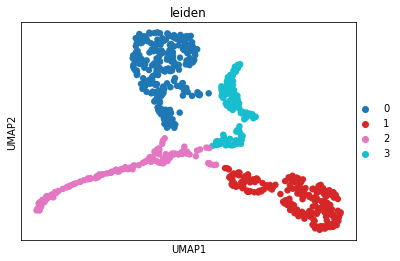

In [47]:
sc.pp.normalize_per_cell(tenx, counts_per_cell_after=10000)

sc.pp.neighbors(tenx)

sc.tl.umap(tenx)

sc.tl.leiden(tenx, resolution=0.1)

sc.pl.umap(tenx, color='leiden', palette='tab10')

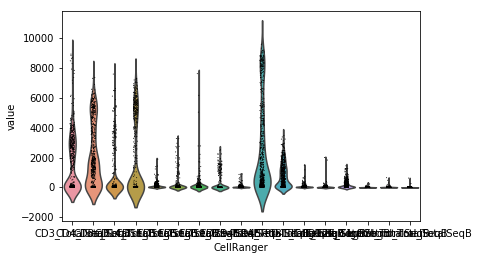

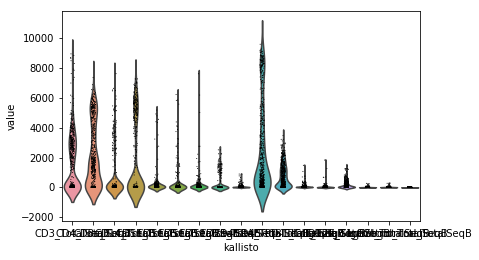

In [48]:
sc.pl.violin(tenx, keys=list(tenx.var_names)[-17:], xlabel='CellRanger')
sc.pl.violin(genes, keys=list(tenx.var_names)[-17:], xlabel='kallisto')

In [49]:
genes.var_names

Index(['CD3_TotalSeqB', 'CD4_TotalSeqB', 'CD8a_TotalSeqB', 'CD14_TotalSeqB',
       'CD15_TotalSeqB', 'CD16_TotalSeqB', 'CD56_TotalSeqB', 'CD19_TotalSeqB',
       'CD25_TotalSeqB', 'CD45RA_TotalSeqB', 'CD45RO_TotalSeqB',
       'PD-1_TotalSeqB', 'TIGIT_TotalSeqB', 'CD127_TotalSeqB',
       'IgG2a_control_TotalSeqB', 'IgG1_control_TotalSeqB',
       'IgG2b_control_TotalSeqB'],
      dtype='object', name=0)

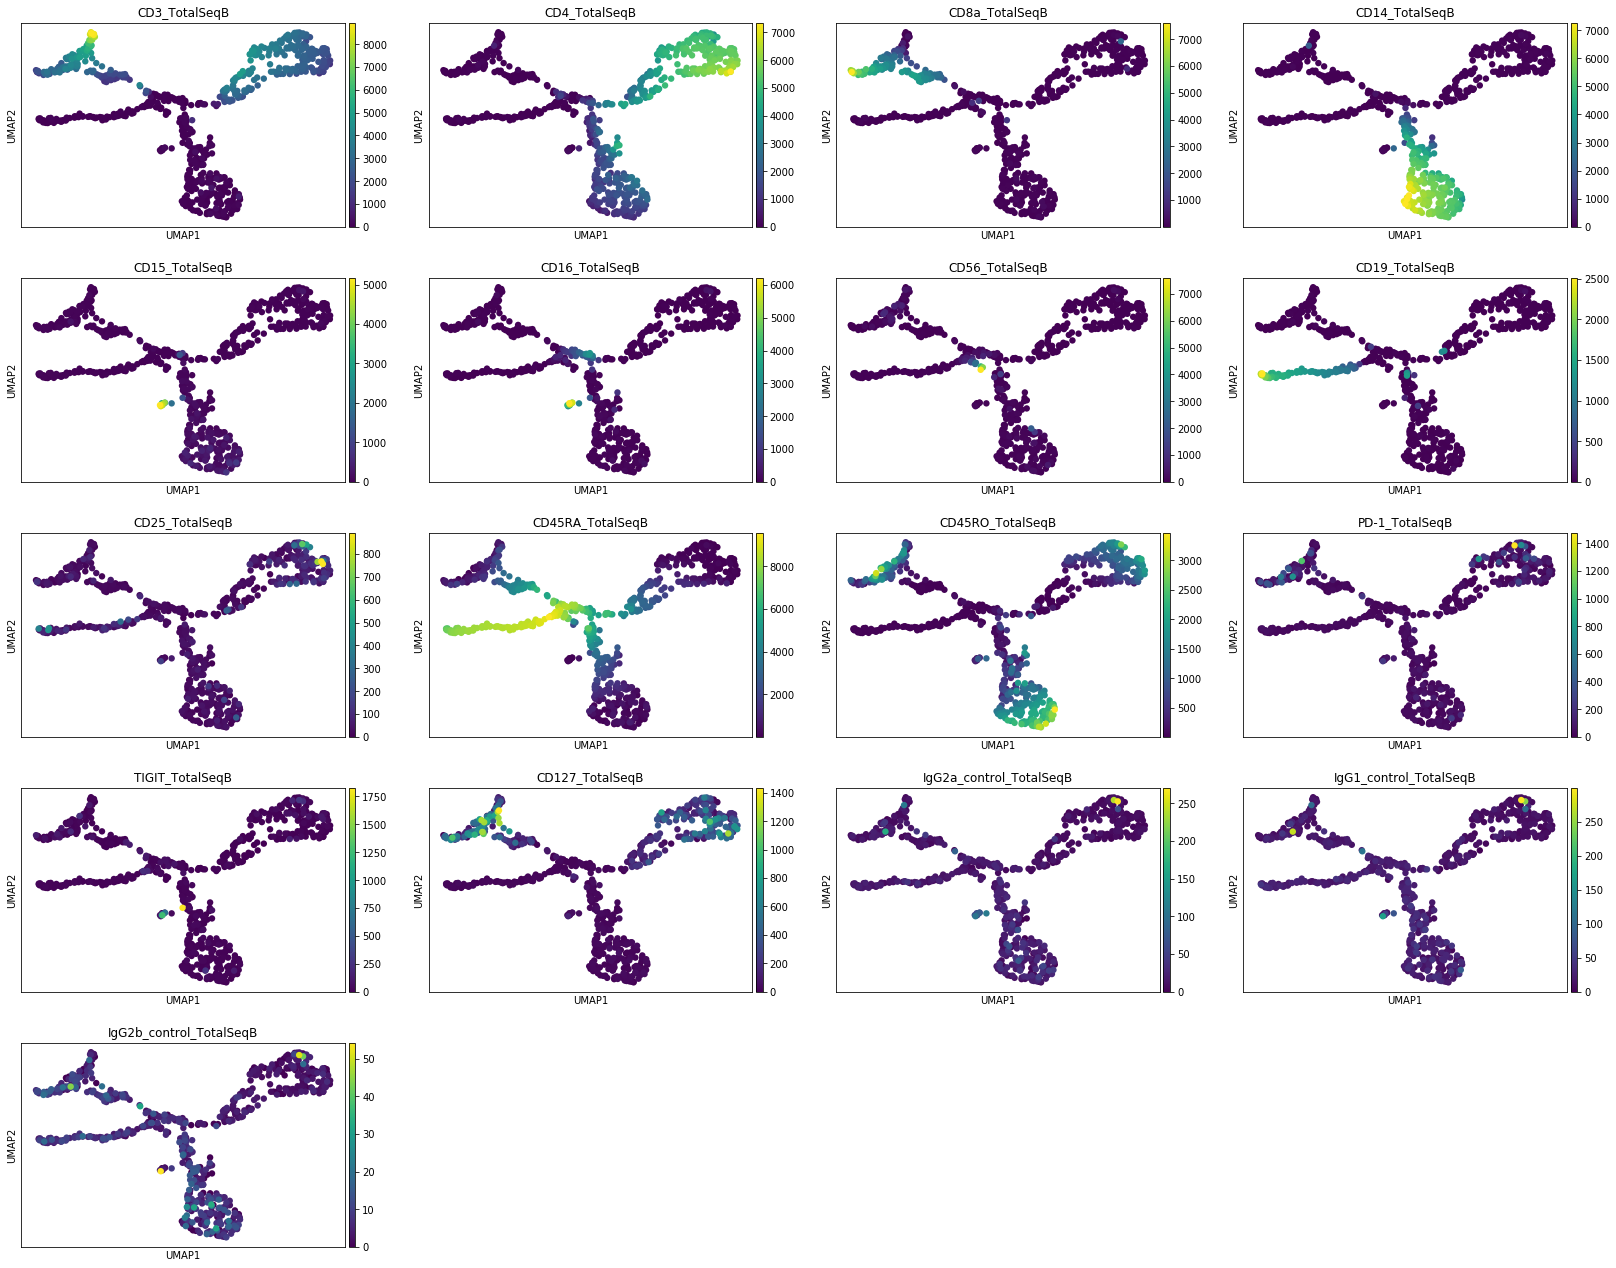

Embedding and Antibody Quantification using kallisto


In [50]:
sc.pl.umap(genes, color=genes.var_names)
print("Embedding and Antibody Quantification using kallisto")

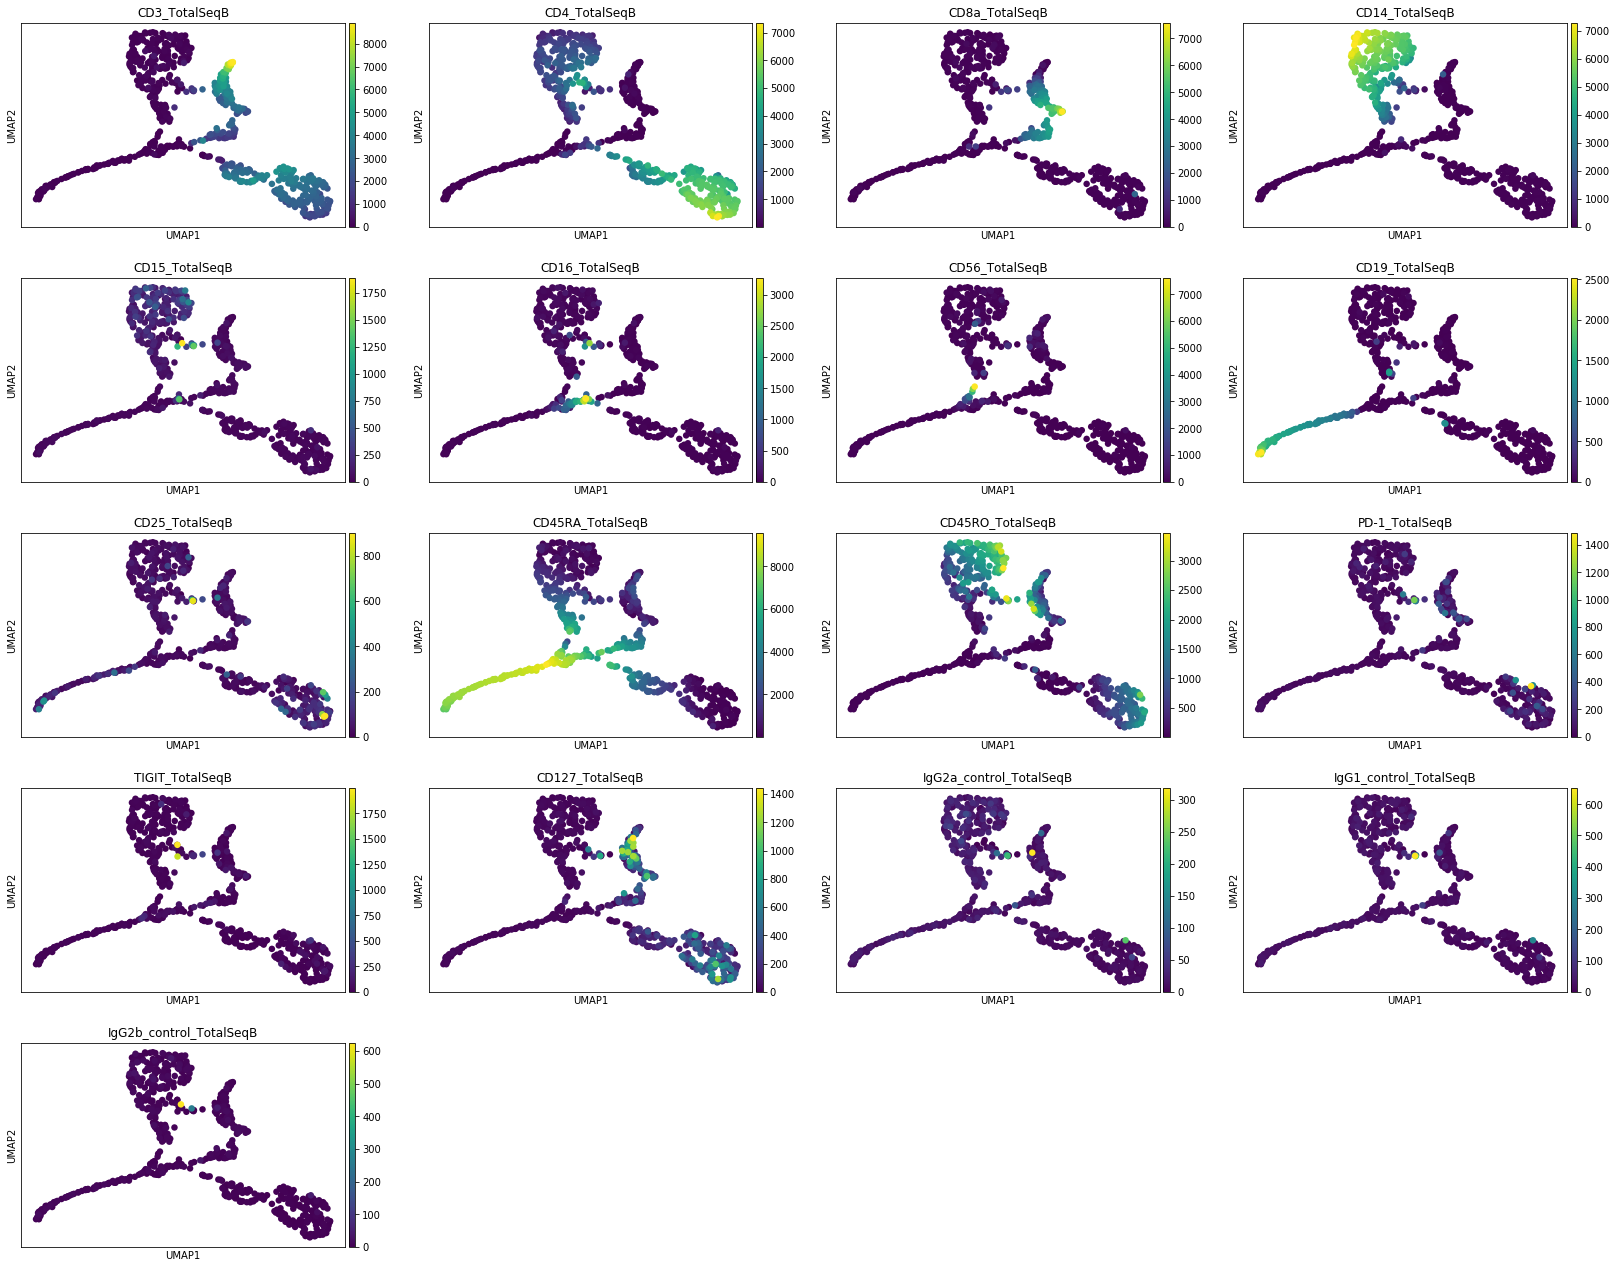

Embedding and Antibody Quantification using CellRanger


In [51]:
sc.pl.umap(tenx, color=genes.var_names)
print("Embedding and Antibody Quantification using CellRanger")

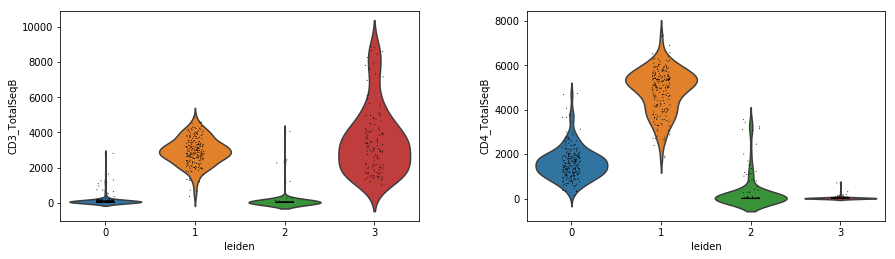

10x CellRanger


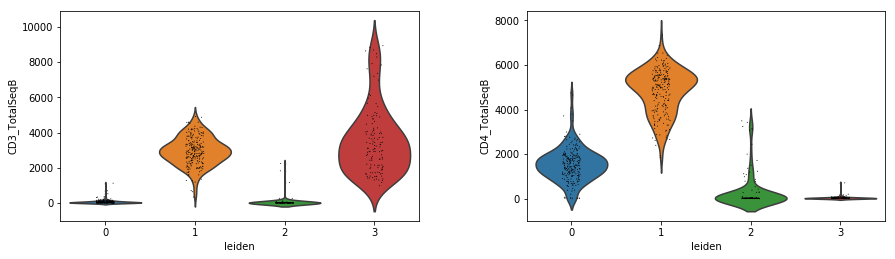

kallisto | bustools


In [52]:
sc.pl.violin(tenx, keys=tenx.var_names[:2], groupby='leiden', title='CellRanger')
print("10x CellRanger")
sc.pl.violin(genes, keys=tenx.var_names[:2], groupby='leiden')
print("kallisto | bustools")

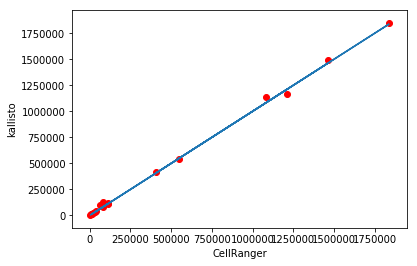

In [53]:
plt.plot(sum(tenx.X).todense().tolist()[0], sum(tenx.X).todense().tolist()[0])
plt.scatter(sum(tenx.X).todense().tolist()[0], sum(genes.X).todense().tolist()[0], color='r')
plt.ylabel("kallisto")
plt.xlabel("CellRanger")
plt.show()

In [54]:
from scipy import stats
import numpy as np

In [55]:
slope, intercept, r_value, p_value, std_err = stats.linregress(sum(tenx.X).todense().tolist()[0],sum(genes.X).todense().tolist()[0])

In [56]:
print("r-squared:", r_value**2)

r-squared: 0.9985021394763447


# TCC Analysis

In [58]:
tcc=sc.read_mtx('./tcc/tcc.mtx').T
tcc

ValueError: column index exceeds matrix dimensions

In [ ]:
genes.var_names=pd.read_csv('/home/jgehring/scRNAseq/kITE/10xTest/genecount/genecounts.genes.txt', header=None)[0]
genes.obs_names=pd.read_csv('/home/jgehring/scRNAseq/kITE/10xTest/genecount/genecounts.barcodes.txt', header=None)[0]


In [ ]:
genes.var_names

In [ ]:
print(sum(genes.X))

In [ ]:
sc.pp.filter_cells(genes,min_counts=0)

In [ ]:
sc.pp.filter_genes(genes,min_counts=0)

In [ ]:
sc.pl.violin(genes, keys='n_counts')

In [ ]:
genes.obs['n_countslog']=np.log1p(genes.obs['n_counts'])

In [ ]:
sc.pl.violin(genes, keys='n_countslog')

In [ ]:
genes.obs_names